## Example: Multiobjective Parameter Estimation for NARMAX models - An Overview

Example created by Gabriel Bueno Leandro, Samir Milani Martins and Wilson Rocha Lacerda Junior

Multiobjective parameter estimation represents a fundamental paradigm shift in the way we approach the parameter tuning problem for NARMAX models. Instead of seeking a single set of parameter values that optimally fits the model to the data, multiobjective approaches aim to identify a set of parameter solutions, known as the Pareto front, that provide a trade-off between competing objectives. These objectives often encompass a spectrum of model performance criteria, such as goodness-of-fit, model complexity, and robustness.

## Reference 

**For further information, check this reference: https://doi.org/10.1080/00207170601185053**.



## Use case: Buck converter
 
<div style="text-align: justify"> A buck converter is a type of DC/DC converter that decreases the voltage (while increasing the current) from its input (power supply) to its output (load). It is similar to a boost converter (elevator) and is a type of switched-mode power supply (SMPS) that typically contains at least two semiconductors (a diode and a transistor, although modern buck converters replace the diode with a second transistor used for synchronous rectification) and at least one energy storage element, a capacitor, inductor or both combined. </div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.multiobjective_parameter_estimation import AILS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_results
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.narmax_tools import set_weights

# Dynamic Behavior

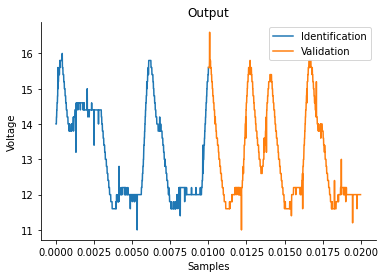

In [2]:
df_train = pd.read_csv(r"datasets/buck_id.csv")
df_valid = pd.read_csv(r"datasets/buck_valid.csv")

# Plotting the measured output (identification and validation data)
plt.figure(1)
plt.title("Output")
plt.plot(df_train.sampling_time, df_train.y, label="Identification", linewidth=1.5)
plt.plot(df_valid.sampling_time, df_valid.y, label="Validation", linewidth=1.5)
plt.xlabel("Samples")
plt.ylabel("Voltage")
plt.legend()
plt.show()

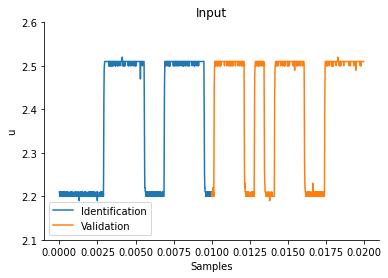

In [3]:
# Plotting the measured input (identification and validation data)
plt.figure(2)
plt.title("Input")
plt.plot(df_train.sampling_time, df_train.input, label="Identification", linewidth=1.5)
plt.plot(df_valid.sampling_time, df_valid.input, label="Validation", linewidth=1.5)
plt.ylim(2.1, 2.6)
plt.ylabel("u")
plt.xlabel("Samples")
plt.legend()
plt.show()

### Buck Converter Static Function

The duty cycle, represented by the symbol $D$, is defined as the ratio of the time the system is on ($T_{on}$​) to the total operation cycle time ($T$). Mathematically, this can be expressed as $D=\frac{T_{on}}{T}$. The complement of the duty cycle, represented by $D'$, is defined as the ratio of the time the system is off ($T_{off}$) to the total operation cycle time ($T$) and can be expressed as $D'=\frac{T_{off}}{T}$.

The load voltage ($V_o$) is related to the source voltage ($V_d$) by the equation $V_o​=D⋅V_d​=(1−D’)⋅V_d$.  For this particular converter, it is known that $D′=\frac{\bar{u}-1}{3}​$,​ which means that the static function of this system can be derived from theory to be:

$$
V_o = \frac{4V_d}{3} - \frac{V_d}{3}\cdot \bar{u}
$$

If we assume that the source voltage $V_d$​ is equal to 24 V, then we can rewrite the above expression as follows:

$$
V_o = (4 - \bar{u})\cdot 8
$$

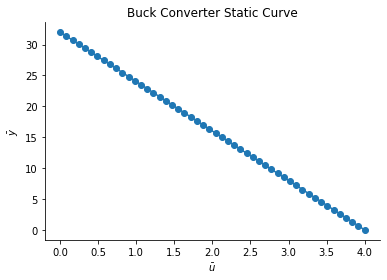

In [4]:
# Static data
Vd = 24
Uo = np.linspace(0, 4, 50)
Yo = (4 - Uo) * Vd / 3
Uo = Uo.reshape(-1, 1)
Yo = Yo.reshape(-1, 1)
plt.figure(3)
plt.title("Buck Converter Static Curve")
plt.xlabel("$\\bar{u}$")
plt.ylabel("$\\bar{y}$")
plt.plot(Uo, Yo, linewidth=1.5, linestyle="-", marker="o")
plt.show()

### Buck converter Static Gain

The gain of a Buck converter is a measure of how its output voltage changes in response to changes in its input voltage. Mathematically, the gain can be calculated as the derivative of the converter’s static function, which describes the relationship between its input and output voltages.
In this case, the static function of the Buck converter is given by the equation:

$$
V_o = (4 - \bar{u})\cdot 8
$$

Taking the derivative of this equation with respect to $\hat{u}$, we find that the gain of the Buck converter is equal to −8. In other words, for every unit increase in the input voltage $\hat{u}$, the output voltage Vo​ will decrease by 8 units.

so $gain=V_o'=-8$

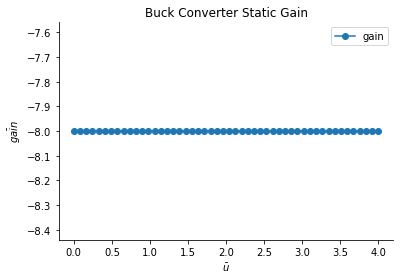

In [5]:
# Defining the gain
gain = -8 * np.ones(len(Uo)).reshape(-1, 1)
plt.figure(3)
plt.title("Buck Converter Static Gain")
plt.xlabel("$\\bar{u}$")
plt.ylabel("$\\bar{gain}$")
plt.plot(Uo, gain, linewidth=1.5, label="gain", linestyle="-", marker="o")
plt.legend()
plt.show()

### Building a dynamic model using the mono-objective approach

In [6]:
x_train = df_train.input.values.reshape(-1, 1)
y_train = df_train.y.values.reshape(-1, 1)
x_valid = df_valid.input.values.reshape(-1, 1)
y_valid = df_valid.y.values.reshape(-1, 1)

basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_info_values=8,
    extended_least_squares=False,
    ylag=2,
    xlag=2,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)

model.fit(X=x_train, y=y_train)

C:\Users\wilso\Desktop\projects\GitHub\gabriel\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


### Affine Information Least Squares Algorithm (AILS)

AILS is a multiobjective parameter estimation algorithm, based on a set of affine information pairs. The multiobjective approach proposed in the mentioned paper and implemented in SysIdentPy leads to a convex multiobjective optimization problem, which can be solved by AILS. AILS is a LeastSquares-type non-iterative scheme for finding the Pareto-set solutions for the multiobjective problem.

So, with the model structure defined (we will be using the one built using the dynamic data above), one can estimate the parameters using the multiobjective approach.

The information about static function and static gain, besides the usual dynamic input/output data, can be used to build the pair of affine information to estimate the parameters of the model. We can model the cost function as:

$$
\gamma(\hat\theta) = w_1\cdot J_{LS}(\hat{\theta})+w_2\cdot J_{SF}(\hat{\theta})+w_3\cdot J_{SG}(\hat{\theta})
$$


### Multiobjective parameter estimation considering 3 different objectives: the prediction error, the static function and the static gain 

In [7]:
# you can use any set of model structure you want in your use case, but in this notebook we will use the one obtained above the compare with other work
mo_estimator = AILS(final_model=model.final_model)

# setting the log-spaced weights of each objective function
w = set_weights(static_function=True, static_gain=True)

# you can also use something like

# w = np.array(
#     [
#         [0.98, 0.7, 0.5, 0.35, 0.25, 0.01, 0.15, 0.01],
#         [0.01, 0.1, 0.3, 0.15, 0.25, 0.98, 0.35, 0.01],
#         [0.01, 0.2, 0.2, 0.50, 0.50, 0.01, 0.50, 0.98],
#     ]
# )

# to set the weights. Each row correspond to each objective

AILS has an `estimate` method that returns the cost functions (J), the Euclidean norm of the cost functions (E), the estimated parameters referring to each weight (theta), the regressor matrix of the gain and static_function affine information HR and QR, respectively.


In [8]:
J, E, theta, HR, QR, position = mo_estimator.estimate(
    X=x_train, y=y_train, gain=gain, y_static=Yo, X_static=Uo, weighing_matrix=w
)
result = {
    "w1": w[0, :],
    "w2": w[2, :],
    "w3": w[1, :],
    "J_ls": J[0, :],
    "J_sg": J[1, :],
    "J_sf": J[2, :],
    "||J||:": E,
}
pd.DataFrame(result)

,w1,w2,w3,J_ls,J_sg,J_sf,||J||:
0,0.006842,0.003078,0.990080,0.999970,1.095045e-05,0.000013,0.245244
1,0.007573,0.002347,0.990080,0.999938,2.294701e-05,0.000016,0.245236
2,0.008382,0.001538,0.990080,0.999885,6.505062e-05,0.000018,0.245223
3,0.009277,0.000642,0.990080,0.999717,4.505632e-04,0.000021,0.245183
4,0.006842,0.098663,0.894495,1.000000,7.393225e-08,0.000015,0.245252
...,...,...,...,...,...,...,...
2290,0.659632,0.333527,0.006842,0.995896,3.965701e-04,1.000000,0.244489
2291,0.730119,0.263039,0.006842,0.995632,5.602985e-04,0.972841,0.244412
2292,0.808139,0.185020,0.006842,0.995364,8.321075e-04,0.868299,0.244300
2293,0.894495,0.098663,0.006842,0.995100,1.365000e-03,0.660485,0.244160


Now we can set theta related to any weight results

In [9]:
model.theta = theta[-1, :].reshape(
    -1, 1
)  # setting the theta estimated for the last combination of the weights
# the model structure is exactly the same, but the order of the regressors is changed in estimate method. Thats why you have to change the model.final_model
model.final_model = mo_estimator.final_model
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=3,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
r

,Regressors,Parameters,ERR
0,1,2.2930E+00,9.999E-01
1,y(k-1),2.3307E-01,2.042E-05
2,y(k-2),6.3209E-01,1.108E-06
3,x1(k-1),-5.9333E-01,4.688E-06
4,y(k-1)^2,2.7673E-01,3.922E-07
5,y(k-2)y(k-1),-5.3228E-01,8.389E-07
6,x1(k-1)y(k-1),1.6667E-02,5.690E-07
7,y(k-2)^2,2.5766E-01,3.827E-06


### The dynamic results for that chosen theta is

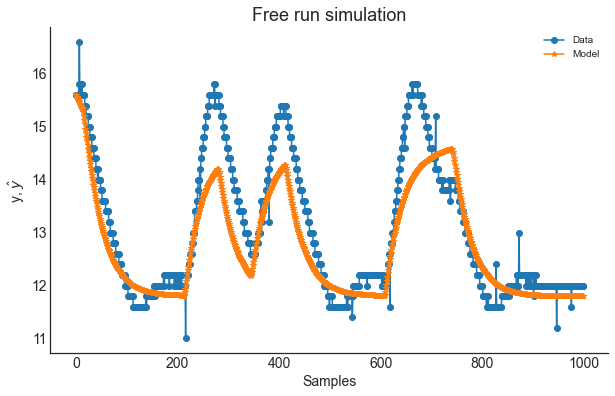

In [10]:
plot_results(y=y_valid, yhat=yhat, n=1000)

### The static gain result is

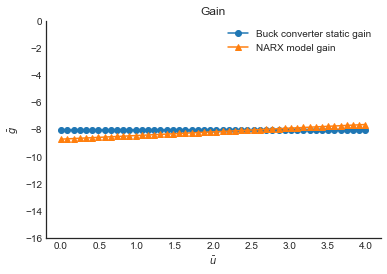

In [11]:
plt.figure(4)
plt.title("Gain")
plt.plot(
    Uo,
    gain,
    linewidth=1.5,
    linestyle="-",
    marker="o",
    label="Buck converter static gain",
)
plt.plot(
    Uo,
    HR.dot(model.theta),
    linestyle="-",
    marker="^",
    linewidth=1.5,
    label="NARX model gain",
)
plt.xlabel("$\\bar{u}$")
plt.ylabel("$\\bar{g}$")
plt.ylim(-16, 0)
plt.legend()
plt.show()

### The static function result is

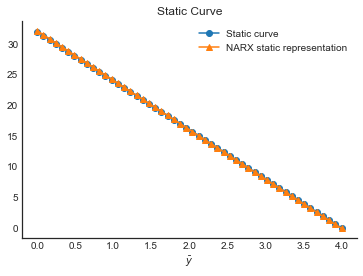

In [12]:
plt.figure(5)
plt.title("Static Curve")
plt.plot(Uo, Yo, linewidth=1.5, label="Static curve", linestyle="-", marker="o")
plt.plot(
    Uo,
    QR.dot(model.theta),
    linewidth=1.5,
    label="NARX ​​static representation",
    linestyle="-",
    marker="^",
)
plt.xlabel("$\\bar{u}$")
plt.xlabel("$\\bar{y}$")
plt.legend()
plt.show()

### Getting the best weight combination based on the norm of the cost function

      Regressors   Parameters        ERR
0              1   1.5405E+00  9.999E-01
1         y(k-1)   2.9687E-01  2.042E-05
2         y(k-2)   6.4693E-01  1.108E-06
3        x1(k-1)  -4.1302E-01  4.688E-06
4       y(k-1)^2   2.7671E-01  3.922E-07
5   y(k-2)y(k-1)  -5.3474E-01  8.389E-07
6  x1(k-1)y(k-1)   4.0624E-03  5.690E-07
7       y(k-2)^2   2.5832E-01  3.827E-06


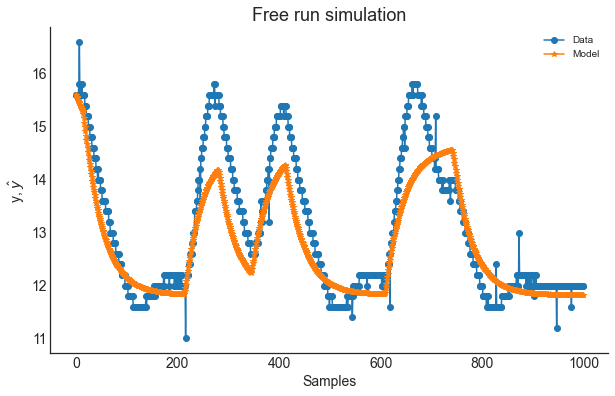

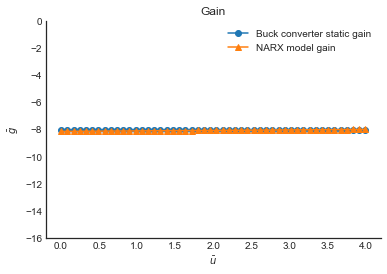

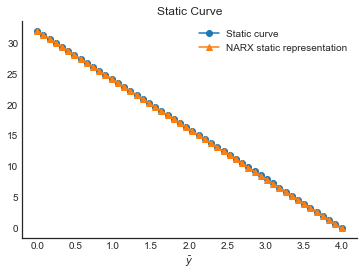

In [13]:
# the variable `position` returned in `estimate` method give the position of the best weight combination
model.theta = theta[position, :].reshape(
    -1, 1
)  # setting the theta estimated for the best combination of the weights
# the model structure is exactly the same, but the order of the regressors is changed in estimate method. Thats why you have to change the model.final_model
model.final_model = mo_estimator.final_model
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=3,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

# The dynamic results for that chosen theta is
plot_results(y=y_valid, yhat=yhat, n=1000)
# The static gain result is
plt.figure(4)
plt.title("Gain")
plt.plot(
    Uo,
    gain,
    linewidth=1.5,
    linestyle="-",
    marker="o",
    label="Buck converter static gain",
)
plt.plot(
    Uo,
    HR.dot(model.theta),
    linestyle="-",
    marker="^",
    linewidth=1.5,
    label="NARX model gain",
)
plt.xlabel("$\\bar{u}$")
plt.ylabel("$\\bar{g}$")
plt.ylim(-16, 0)
plt.legend()
plt.show()
# The static function result is
plt.figure(5)
plt.title("Static Curve")
plt.plot(Uo, Yo, linewidth=1.5, label="Static curve", linestyle="-", marker="o")
plt.plot(
    Uo,
    QR.dot(model.theta),
    linewidth=1.5,
    label="NARX ​​static representation",
    linestyle="-",
    marker="^",
)
plt.xlabel("$\\bar{u}$")
plt.xlabel("$\\bar{y}$")
plt.legend()
plt.show()

You can also plot the pareto-set solutions

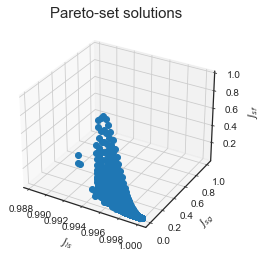

In [14]:
plt.figure(6)
ax = plt.axes(projection="3d")
ax.plot3D(J[0, :], J[1, :], J[2, :], "o", linewidth=0.1)
ax.set_title("Pareto-set solutions", fontsize=15)
ax.set_xlabel("$J_{ls}$", fontsize=10)
ax.set_ylabel("$J_{sg}$", fontsize=10)
ax.set_zlabel("$J_{sf}$", fontsize=10)
plt.show()

### Details about the method

The polynomial NARX model built using the mono-objective approach has the following structure:

$$
y(k) = \theta_1 y(k-1) + \theta_2 y(k-2) + \theta_3 u(k-1) y(k-1) + \theta_4 + \theta_5 y(k-1)^2 + \theta_6 u(k-1) + \theta_7 y(k-2)y(k-1) + \theta_8 y(k-2)^2
$$

The, the goal when using the static function and static gain information in the multiobjective scenario is to estimate the vector $\hat{\theta}$ based on:

$$
\theta = [w_1\Psi^T\Psi + w_2(HR)^T(HR) + w_3(QR)(QR)^T]^{-1} [w_1\Psi^T y + w_2(HR)^T\overline{g}+w_3(QR)^T\overline{y}]
$$

The $\Psi$ matrix is built using the usual mono-objective dynamic modeling approach in SysIdentPy. However, it is still necessary to find the Q, H and R matrices. AILS have the methods to compute all of those matrices. Basically, to do that, $q_i^T$ is first estimated:

$$
q_i^T = 
\begin{bmatrix}
1 & \overline{y_i} & \overline{u_1} & \overline{y_i}^2 & \cdots & \overline{y_i}^l &  F_{yu} & \overline{u_i}^2 & \cdots & \overline{u_i}^l
\end{bmatrix}
$$

where $F_{yu}$ stands for all non-linear monomials in the model that are related to $y(k)$ and $u(k)$, $l$ is the largest non-linearity in the model for input and output terms. For a model with a degree of nonlinearity equal to 2, we can obtain:

$$
q_i^T = 
\begin{bmatrix}
1 & \overline{y_i} & \overline{u_i} & \overline{y_i}^2 & \overline{u_i}\:\overline{y_i} & \overline{u_i}^2 
\end{bmatrix}
$$

It is possible to encode the $q_i^T$ matrix so that it follows the model encoding defined in SysIdentPy. To do this, 0 is considered as a constant, $y_i$ equal to 1 and $u_i$ equal to 2. The number of columns indicates the degree of nonlinearity of the system and the number of rows reflects the number of terms:

$$
q_i = 
\begin{bmatrix}
0 & 0\\
1 & 0\\
2 & 0\\
1 & 1\\
2 & 1\\
2 & 2\\
\end{bmatrix}
= 
\begin{bmatrix}
1 \\
\overline{y_i}\\
\overline{u_i}\\
\overline{y_i}^2\\
\overline{u_i}\:\overline{y_i}\\
\overline{u_i}^2\\
\end{bmatrix}
$$

Finally, the result can be easily obtained using the ‘regressor_space’ method of SysIdentPy

In [15]:
from sysidentpy.narmax_base import RegressorDictionary

object_qit = RegressorDictionary(xlag=1, ylag=1)
R_example = object_qit.regressor_space(n_inputs=1) // 1000
print(f"R = {R_example}")

R = [[0 0]
 [1 0]
 [2 0]
 [1 1]
 [2 1]
 [2 2]]


such that:

$$
\overline{y_i} = q_i^T R\theta
$$

and:

$$
\overline{g_i} = H R\theta
$$

where $R$ is the linear mapping of the static regressors represented by $q_i^T$. In addition, the $H$ matrix holds affine information regarding $\overline{g_i}$, which is equal to $\overline{g_i} = \frac{d\overline{y}}{d\overline{u}}{\big |}_{(\overline{u_i}\:\overline{y_i})}$.

From now on, we will begin to apply the parameter estimation in a multiobjective manner. This will be done with the NARX polynomial model of the BUCK converter in mind. In this context, $q_i^T$ will be generic and will assume a specific format for the problem at hand. For this task, the $R_qit$ method will be used, whose objective is to return the $q_i^T$ related to the model and the matrix of the linear mapping $R$:

In [16]:
R, qit = mo_estimator.build_linear_mapping()
print("R matrix:")
print(R)
print("qit matrix:")
print(qit)

R matrix:
[[1 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 1]
 [0 0 0 0 0 0 1 0]]
qit matrix:
[[0 0]
 [1 0]
 [0 1]
 [2 0]
 [1 1]]


So

$$
q_i = 
\begin{bmatrix}
0 & 0\\
1 & 0\\
2 & 0\\
1 & 1\\
2 & 1\\ 
\end{bmatrix}
=
\begin{bmatrix}
1\\
\overline{y}\\
\overline{u}\\
\overline{y^2}\\
\overline{u}\:\overline{y}\\ 
\end{bmatrix}
$$

You can notice that the method produces outputs consistent with what is expected:

$$
y(k) = \theta_1 y(k-1) + \theta_2 y(k-2) + \theta_3 u(k-1) y(k-1) + \theta_4 + \theta_5 y(k-1)^2 + \theta_6 u(k-1) + \theta_7 y(k-2)y(k-1) + \theta_8 y(k-2)^2
$$

and:

$$ 
R = 
\begin{bmatrix}
term/\theta & \theta_1 & \theta_2 & \theta_3 & \theta_4 & \theta_5 & \theta_6 & \theta_7 & \theta_8\\
1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
\overline{y} & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
\overline{u} & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
\overline{y^2} & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 1\\
\overline{y}\:\overline{u} & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix}
$$

## Validation

The following model structure will be used to validate the approach:

$$
y(k) = \theta_1 y(k-1) + \theta_2 y(k-2) + \theta_3 + \theta_4 u(k-1) + \theta_5 u(k-1)^2 + \theta_6 u(k-2)u(k-1)+\theta_7 u(k-2) + \theta_8 u(k-2)^2
$$

$\therefore$

$$
model\_final = 
\begin{bmatrix}
1001 & 0\\
1002 & 0\\
0 & 0\\
2001 & 0\\
2001 & 2001\\
2002 & 2001\\
2002 & 0\\
2002 & 2002
\end{bmatrix}
$$

defining in code:

In [17]:
model_final = np.array(
    [
        [1001, 0],
        [1002, 0],
        [0, 0],
        [2001, 0],
        [2001, 2001],
        [2002, 2001],
        [2002, 0],
        [2002, 2002],
    ]
)
model_final

array([[1001,    0],
       [1002,    0],
       [   0,    0],
       [2001,    0],
       [2001, 2001],
       [2002, 2001],
       [2002,    0],
       [2002, 2002]])

In [18]:
mult2 = AILS(final_model=model_final)

In [19]:
def psi(X, Y):
    PSI = np.zeros((len(X), 8))
    for k in range(2, len(Y)):
        PSI[k, 0] = Y[k - 1]
        PSI[k, 1] = Y[k - 2]
        PSI[k, 2] = 1
        PSI[k, 3] = X[k - 1]
        PSI[k, 4] = X[k - 1] ** 2
        PSI[k, 5] = X[k - 2] * X[k - 1]
        PSI[k, 6] = X[k - 2]
        PSI[k, 7] = X[k - 2] ** 2
    return np.delete(PSI, [0, 1], axis=0)

The value of theta with the lowest mean squared error obtained with the same code implemented in Scilab was:

$$
W_{LS} = 0,3612343
$$

and:

$$
W_{SG} = 0,3548699
$$

and:

$$
W_{SF} = 0,3548699
$$

In [20]:
PSI = psi(x_train, y_train)
w = np.array([[0.3612343], [0.2838959], [0.3548699]])

In [21]:
J, E, theta, HR, QR, position = mult2.estimate(
    y=y_train, X=x_train, gain=gain, y_static=Yo, X_static=Uo, weighing_matrix=w
)
result = {
    "w1": w[0, :],
    "w2": w[2, :],
    "w3": w[1, :],
    "J_ls": J[0, :],
    "J_sg": J[1, :],
    "J_sf": J[2, :],
    "||J||:": E,
}
# the order of the weights is different because the way we implemented in Python, but the results are very close as expected
pd.DataFrame(result)

,w1,w2,w3,J_ls,J_sg,J_sf,||J||:
0,0.361234,0.35487,0.283896,1.0,1.0,1.0,1.0


Dynamic results

In [22]:
model.theta = theta[position, :].reshape(-1, 1)
model.final_model = mult2.final_model
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=3,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
r

,Regressors,Parameters,ERR
0,1,1.4287E+00,9.999E-01
1,y(k-1),5.5147E-01,2.042E-05
2,y(k-2),4.0449E-01,1.108E-06
3,x1(k-1),-1.2605E+01,4.688E-06
4,x1(k-2),1.2257E+01,3.922E-07
5,x1(k-1)^2,8.3274E+00,8.389E-07
6,x1(k-2)x1(k-1),-1.1416E+01,5.690E-07
7,x1(k-2)^2,3.0846E+00,3.827E-06


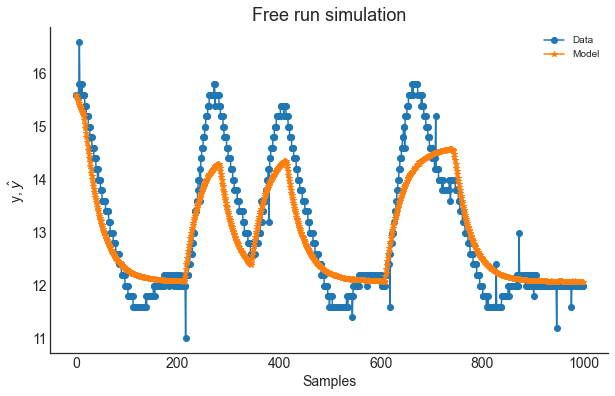

In [23]:
plot_results(y=y_valid, yhat=yhat, n=1000)

Static gain

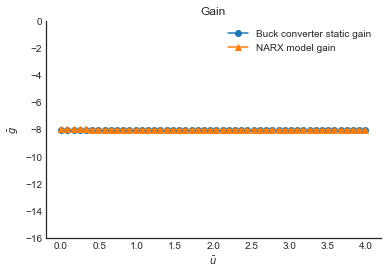

In [24]:
plt.figure(7)
plt.title("Gain")
plt.plot(
    Uo,
    gain,
    linewidth=1.5,
    linestyle="-",
    marker="o",
    label="Buck converter static gain",
)
plt.plot(
    Uo,
    HR.dot(model.theta),
    linestyle="-",
    marker="^",
    linewidth=1.5,
    label="NARX model gain",
)
plt.xlabel("$\\bar{u}$")
plt.ylabel("$\\bar{g}$")
plt.ylim(-16, 0)
plt.legend()
plt.show()

Static function

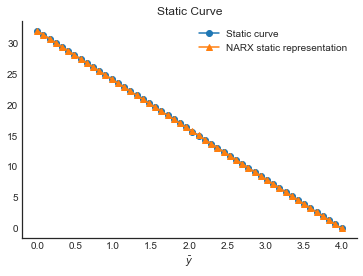

In [25]:
plt.figure(8)
plt.title("Static Curve")
plt.plot(Uo, Yo, linewidth=1.5, label="Static curve", linestyle="-", marker="o")
plt.plot(
    Uo,
    QR.dot(model.theta),
    linewidth=1.5,
    label="NARX ​​static representation",
    linestyle="-",
    marker="^",
)
plt.xlabel("$\\bar{u}$")
plt.xlabel("$\\bar{y}$")
plt.legend()
plt.show()

Pareto-set solutions

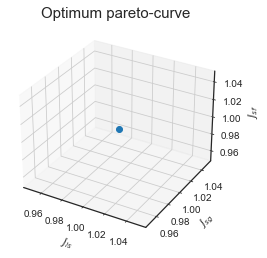

In [26]:
plt.figure(9)
ax = plt.axes(projection="3d")
ax.plot3D(J[0, :], J[1, :], J[2, :], "o", linewidth=0.1)
ax.set_title("Optimum pareto-curve", fontsize=15)
ax.set_xlabel("$J_{ls}$", fontsize=10)
ax.set_ylabel("$J_{sg}$", fontsize=10)
ax.set_zlabel("$J_{sf}$", fontsize=10)
plt.show()

In [27]:
theta[position, :]

array([  1.42867821,   0.5514725 ,   0.40449005, -12.60548863,
        12.25729955,   8.32740057, -11.41574116,   3.08461195])

The following table show the results reported in ‘IniciacaoCientifica2007’ and the ones obtained with SysIdentPy implementation

| Theta       | SysIdentPy   | IniciacaoCientifica2007       |
|-------------|--------------|-------------------------------|
| $\theta_1$  | 0.5514725    | 0.549144                      |
| $\theta_2$  | 0.40449005   | 0.408028                      |
| $\theta_3$  | 1.42867821   | 1.45097                       |
| $\theta_4$  | -12.60548863 | -12.55788                     |
| $\theta_5$  | 8.32740057   | 8.1516315                     |
| $\theta_6$  | -11.41574116 | -11.09728                     |
| $\theta_7$  | 12.25729955  | 12.215782                     |
| $\theta_8$  | 3.08461195   | 2.9319577                     |

where:
$$
E_{Scilab} =    17,426613
$$

and:

$$
E_{Python} = 17,474865
$$

#### Note: as mentioned before, the order of the regressors in the model change, but it is the same structure. The tables shows the respective regressor parameter concerning `SysIdentPy` and `IniciacaoCientifica2007`,  but the order `θ₁`, `θ₂` and so on are not the same of the ones in model.final_model

In [28]:
R, qit = mult2.build_linear_mapping()
print("R matrix:")
print(R)
print("qit matrix:")
print(qit)

R matrix:
[[1 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 1 1]]
qit matrix:
[[0 0]
 [1 0]
 [0 1]
 [0 2]]


model's structure that will be utilized (‘IniciacaoCientifica2007’):

$$
y(k) = \theta_1 y(k-1) + \theta_2 y(k-2) + \theta_3 + \theta_4 u(k-1) + \theta_5 u(k-1)^2 + \theta_6 u(k-2)u(k-1)+\theta_7 u(k-2) + \theta_8 u(k-2)^2
$$

$$
q_i = 
\begin{bmatrix}
0 & 0\\
1 & 0\\
2 & 0\\
2 & 2\\ 
\end{bmatrix}
=
\begin{bmatrix}
1\\
\overline{y}\\
\overline{u}\\
\overline{u^2}
\end{bmatrix}
$$

and:

$$ 
R = 
\begin{bmatrix}
term/\theta & \theta_1 & \theta_2 & \theta_3 & \theta_4 & \theta_5 & \theta_6 & \theta_7 & \theta_8\\
1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
\overline{y} & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
\overline{u} & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0\\
\overline{u^2} & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 1
\end{bmatrix}
$$

consistent with matrix R:

R = [0 0 1 0 0 0 0 0;1 1 0 0 0 0 0 0;0 0 0 1 0 0 1 0;0 0 0 0 1 1 0 1]; // R 

or:

$$ 
R = 
\begin{bmatrix}
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1 & 1 & 0 & 1
\end{bmatrix}
$$

### Biobjective optimization: An use case applied to Buck converter CC-CC using as objectives the static curve information and the prediction error (dynamic) 

In [29]:
bi_objective = AILS(
    static_function=True, static_gain=False, final_model=model_final, normalize=True
)

the value of theta with the lowest mean squared error obtained through the routine in Scilab was:

$$
W_{LS} = 0,9931126
$$

and:

$$
W_{SF} = 0,0068874
$$

In [30]:
w = np.zeros((2, 2000))
w[0, :] = np.logspace(-0.01, -6, num=2000, base=2.71)
w[1, :] = np.ones(2000) - w[0, :]
J, E, theta, HR, QR, position = bi_objective.estimate(
    y=y_train, X=x_train, y_static=Yo, X_static=Uo, weighing_matrix=w
)
result = {"w1": w[0, :], "w2": w[1, :], "J_ls": J[0, :], "J_sg": J[1, :], "||J||:": E}
pd.DataFrame(result)

,w1,w2,J_ls,J_sg,||J||:
0,0.990080,0.009920,0.990863,1.000000,0.990939
1,0.987127,0.012873,0.990865,0.987032,0.990939
2,0.984182,0.015818,0.990867,0.974307,0.990939
3,0.981247,0.018753,0.990870,0.961803,0.990940
4,0.978320,0.021680,0.990873,0.949509,0.990941
...,...,...,...,...,...
1995,0.002555,0.997445,0.999993,0.000072,0.999993
1996,0.002547,0.997453,0.999994,0.000072,0.999994
1997,0.002540,0.997460,0.999996,0.000071,0.999996
1998,0.002532,0.997468,0.999998,0.000071,0.999998


In [31]:
model.theta = theta[position, :].reshape(-1, 1)
model.final_model = bi_objective.final_model
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=3,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
r

,Regressors,Parameters,ERR
0,1,1.3873E+00,9.999E-01
1,y(k-1),5.4941E-01,2.042E-05
2,y(k-2),4.0804E-01,1.108E-06
3,x1(k-1),-1.2515E+01,4.688E-06
4,x1(k-2),1.2227E+01,3.922E-07
5,x1(k-1)^2,8.1171E+00,8.389E-07
6,x1(k-2)x1(k-1),-1.1047E+01,5.690E-07
7,x1(k-2)^2,2.9043E+00,3.827E-06


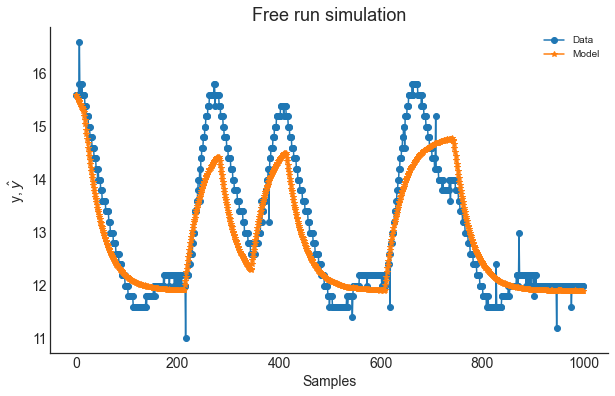

In [32]:
plot_results(y=y_valid, yhat=yhat, n=1000)

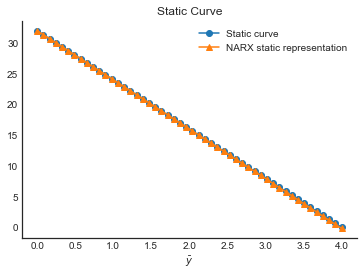

In [33]:
plt.figure(10)
plt.title("Static Curve")
plt.plot(Uo, Yo, linewidth=1.5, label="Static curve", linestyle="-", marker="o")
plt.plot(
    Uo,
    QR.dot(model.theta),
    linewidth=1.5,
    label="NARX ​​static representation",
    linestyle="-",
    marker="^",
)
plt.xlabel("$\\bar{u}$")
plt.xlabel("$\\bar{y}$")
plt.legend()
plt.show()

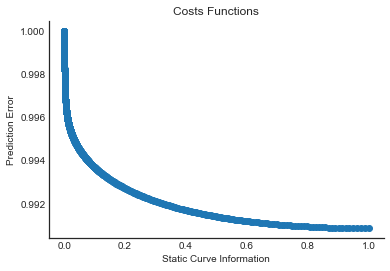

In [34]:
plt.figure(11)
plt.title("Costs Functions")
plt.plot(J[1, :], J[0, :], "o")
plt.xlabel("Static Curve Information")
plt.ylabel("Prediction Error")
plt.show()

where the best estimated $\theta$ is

| Theta       | SysIdentPy   | IniciacaoCientifica2007  |
|-------------|--------------|--------------------------|
| $\theta_1$  | 0.54940883   | 0.5494135                |
| $\theta_2$  | 0.40803995   | 0.4080312                |
| $\theta_3$  | 1.38725684   | 3.3857601                |
| $\theta_4$  | -12.51466378 | -12.513688               |
| $\theta_5$  | 8.11712897   | 8.116575                 |
| $\theta_6$  | -11.04664789 | -11.04592                |
| $\theta_7$  | 12.22693907  | 12.227184                |
| $\theta_8$  | 2.90425844   | 2.9038468                |

where:

$$
E_{Scilab} = 17,408934
$$

and:

$$
E_{Python} = 17,408947
$$

### Multiobjective parameter estimation considering 2 different objectives: the prediction error and the static gain 

In [35]:
bi_objective_gain = AILS(
    static_function=False, static_gain=True, final_model=model_final, normalize=False
)

the value of theta with the lowest mean squared error obtained through the routine in Scilab was:

$$
W_{LS} = 0,9931126
$$

and:

$$
W_{SF} = 0,0068874
$$


In [36]:
w = np.zeros((2, 2000))
w[0, :] = np.logspace(0, -6, num=2000, base=2.71)
w[1, :] = np.ones(2000) - w[0, :]
# W = np.array([[0.9931126],
# [0.0068874]])
J, E, theta, HR, QR, position = bi_objective_gain.estimate(
    X=x_train, y=y_train, gain=gain, y_static=Yo, X_static=Uo, weighing_matrix=w
)
result = {"w1": w[0, :], "w2": w[1, :], "J_ls": J[0, :], "J_sg": J[1, :], "||J||:": E}
pd.DataFrame(result)

,w1,w2,J_ls,J_sg,||J||:
0,1.000000,0.000000,17.407256,3.579467e+01,39.802904
1,0.997012,0.002988,17.407528,2.109260e-01,17.408806
2,0.994033,0.005967,17.407540,2.082067e-01,17.408785
3,0.991063,0.008937,17.407559,2.056636e-01,17.408774
4,0.988102,0.011898,17.407585,2.031788e-01,17.408771
...,...,...,...,...,...
1995,0.002555,0.997445,17.511596,3.340081e-07,17.511596
1996,0.002547,0.997453,17.511596,3.320125e-07,17.511596
1997,0.002540,0.997460,17.511597,3.300289e-07,17.511597
1998,0.002532,0.997468,17.511598,3.280571e-07,17.511598


In [37]:
# Writing the results
model.theta = theta[position, :].reshape(-1, 1)
model.final_model = bi_objective_gain.final_model
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=3,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
r

,Regressors,Parameters,ERR
0,1,1.4853E+00,9.999E-01
1,y(k-1),5.4940E-01,2.042E-05
2,y(k-2),4.0806E-01,1.108E-06
3,x1(k-1),-1.2581E+01,4.688E-06
4,x1(k-2),1.2210E+01,3.922E-07
5,x1(k-1)^2,8.1686E+00,8.389E-07
6,x1(k-2)x1(k-1),-1.1122E+01,5.690E-07
7,x1(k-2)^2,2.9455E+00,3.827E-06


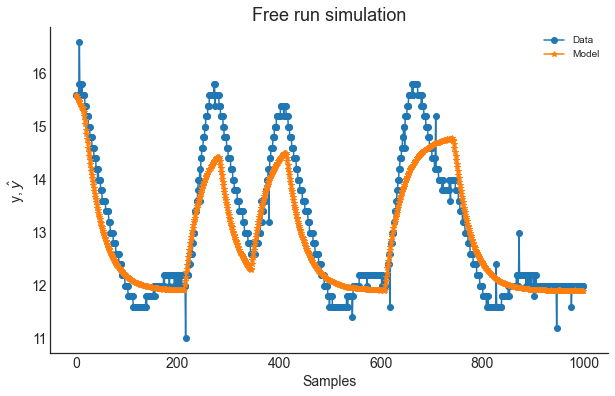

In [38]:
plot_results(y=y_valid, yhat=yhat, n=1000)

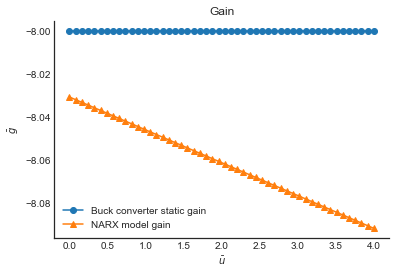

In [39]:
plt.figure(12)
plt.title("Gain")
plt.plot(
    Uo,
    gain,
    linewidth=1.5,
    linestyle="-",
    marker="o",
    label="Buck converter static gain",
)
plt.plot(
    Uo,
    HR.dot(model.theta),
    linestyle="-",
    marker="^",
    linewidth=1.5,
    label="NARX model gain",
)
plt.xlabel("$\\bar{u}$")
plt.ylabel("$\\bar{g}$")
plt.legend()
plt.show()

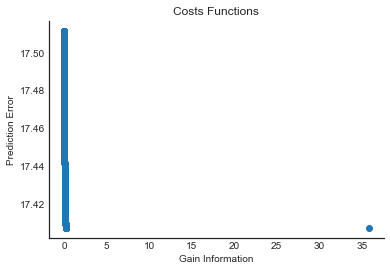

In [40]:
plt.figure(11)
plt.title("Costs Functions")
plt.plot(J[1, :], J[0, :], "o")
plt.xlabel("Gain Information")
plt.ylabel("Prediction Error")
plt.show()

being the selected $\theta$:

| Theta       | SysIdentPy    | IniciacaoCientifica2007   |
|-------------|---------------|---------------------------|
| $\theta_1$  | 0.54939785    | 0.54937289                |
| $\theta_2$  | 0.40805603    | 0.40810168                |
| $\theta_3$  | 1.48525190    | 1.48663719                |
| $\theta_4$  | -12.58066084  | -12.58127183              |
| $\theta_5$  | 8.16862622    | 8.16780294                |
| $\theta_6$  | -11.12171897  | -11.11998621              |
| $\theta_7$  | 12.20954849   | 12.20927355               |
| $\theta_8$  | 2.94548501    | 2.9446532                 |

where:

$$
E_{Scilab} =  17,408997
$$

and:

$$
E_{Python} = 17,408781
$$


### Additional Information

You can also access the matrix Q and H using the following methods

Matrix Q:

In [41]:
bi_objective_gain.build_static_function_information(Uo, Yo)[1]

array([[   50.        ,   800.        ,   800.        ,   100.        ,
          100.        ,   269.3877551 ,   269.3877551 ,   269.3877551 ],
       [  800.        , 17240.81632653, 17240.81632653,  1044.89795918,
         1044.89795918,  2089.79591837,  2089.79591837,  2089.79591837],
       [  800.        , 17240.81632653, 17240.81632653,  1044.89795918,
         1044.89795918,  2089.79591837,  2089.79591837,  2089.79591837],
       [  100.        ,  1044.89795918,  1044.89795918,   269.3877551 ,
          269.3877551 ,   816.32653061,   816.32653061,   816.32653061],
       [  100.        ,  1044.89795918,  1044.89795918,   269.3877551 ,
          269.3877551 ,   816.32653061,   816.32653061,   816.32653061],
       [  269.3877551 ,  2089.79591837,  2089.79591837,   816.32653061,
          816.32653061,  2638.54142407,  2638.54142407,  2638.54142407],
       [  269.3877551 ,  2089.79591837,  2089.79591837,   816.32653061,
          816.32653061,  2638.54142407,  2638.54142407,  2

Matrix H+R:

In [42]:
bi_objective_gain.build_static_gain_information(Uo, Yo, gain)[1]

array([[    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,  3200.        ,  3200.        ,  -400.        ,
         -400.        , -1600.        , -1600.        , -1600.        ],
       [    0.        ,  3200.        ,  3200.        ,  -400.        ,
         -400.        , -1600.        , -1600.        , -1600.        ],
       [    0.        ,  -400.        ,  -400.        ,    50.        ,
           50.        ,   200.        ,   200.        ,   200.        ],
       [    0.        ,  -400.        ,  -400.        ,    50.        ,
           50.        ,   200.        ,   200.        ,   200.        ],
       [    0.        , -1600.        , -1600.        ,   200.        ,
          200.        ,  1077.55102041,  1077.55102041,  1077.55102041],
       [    0.        , -1600.        , -1600.        ,   200.        ,
          200.        ,  1077.55102041,  1077.55102041,  1